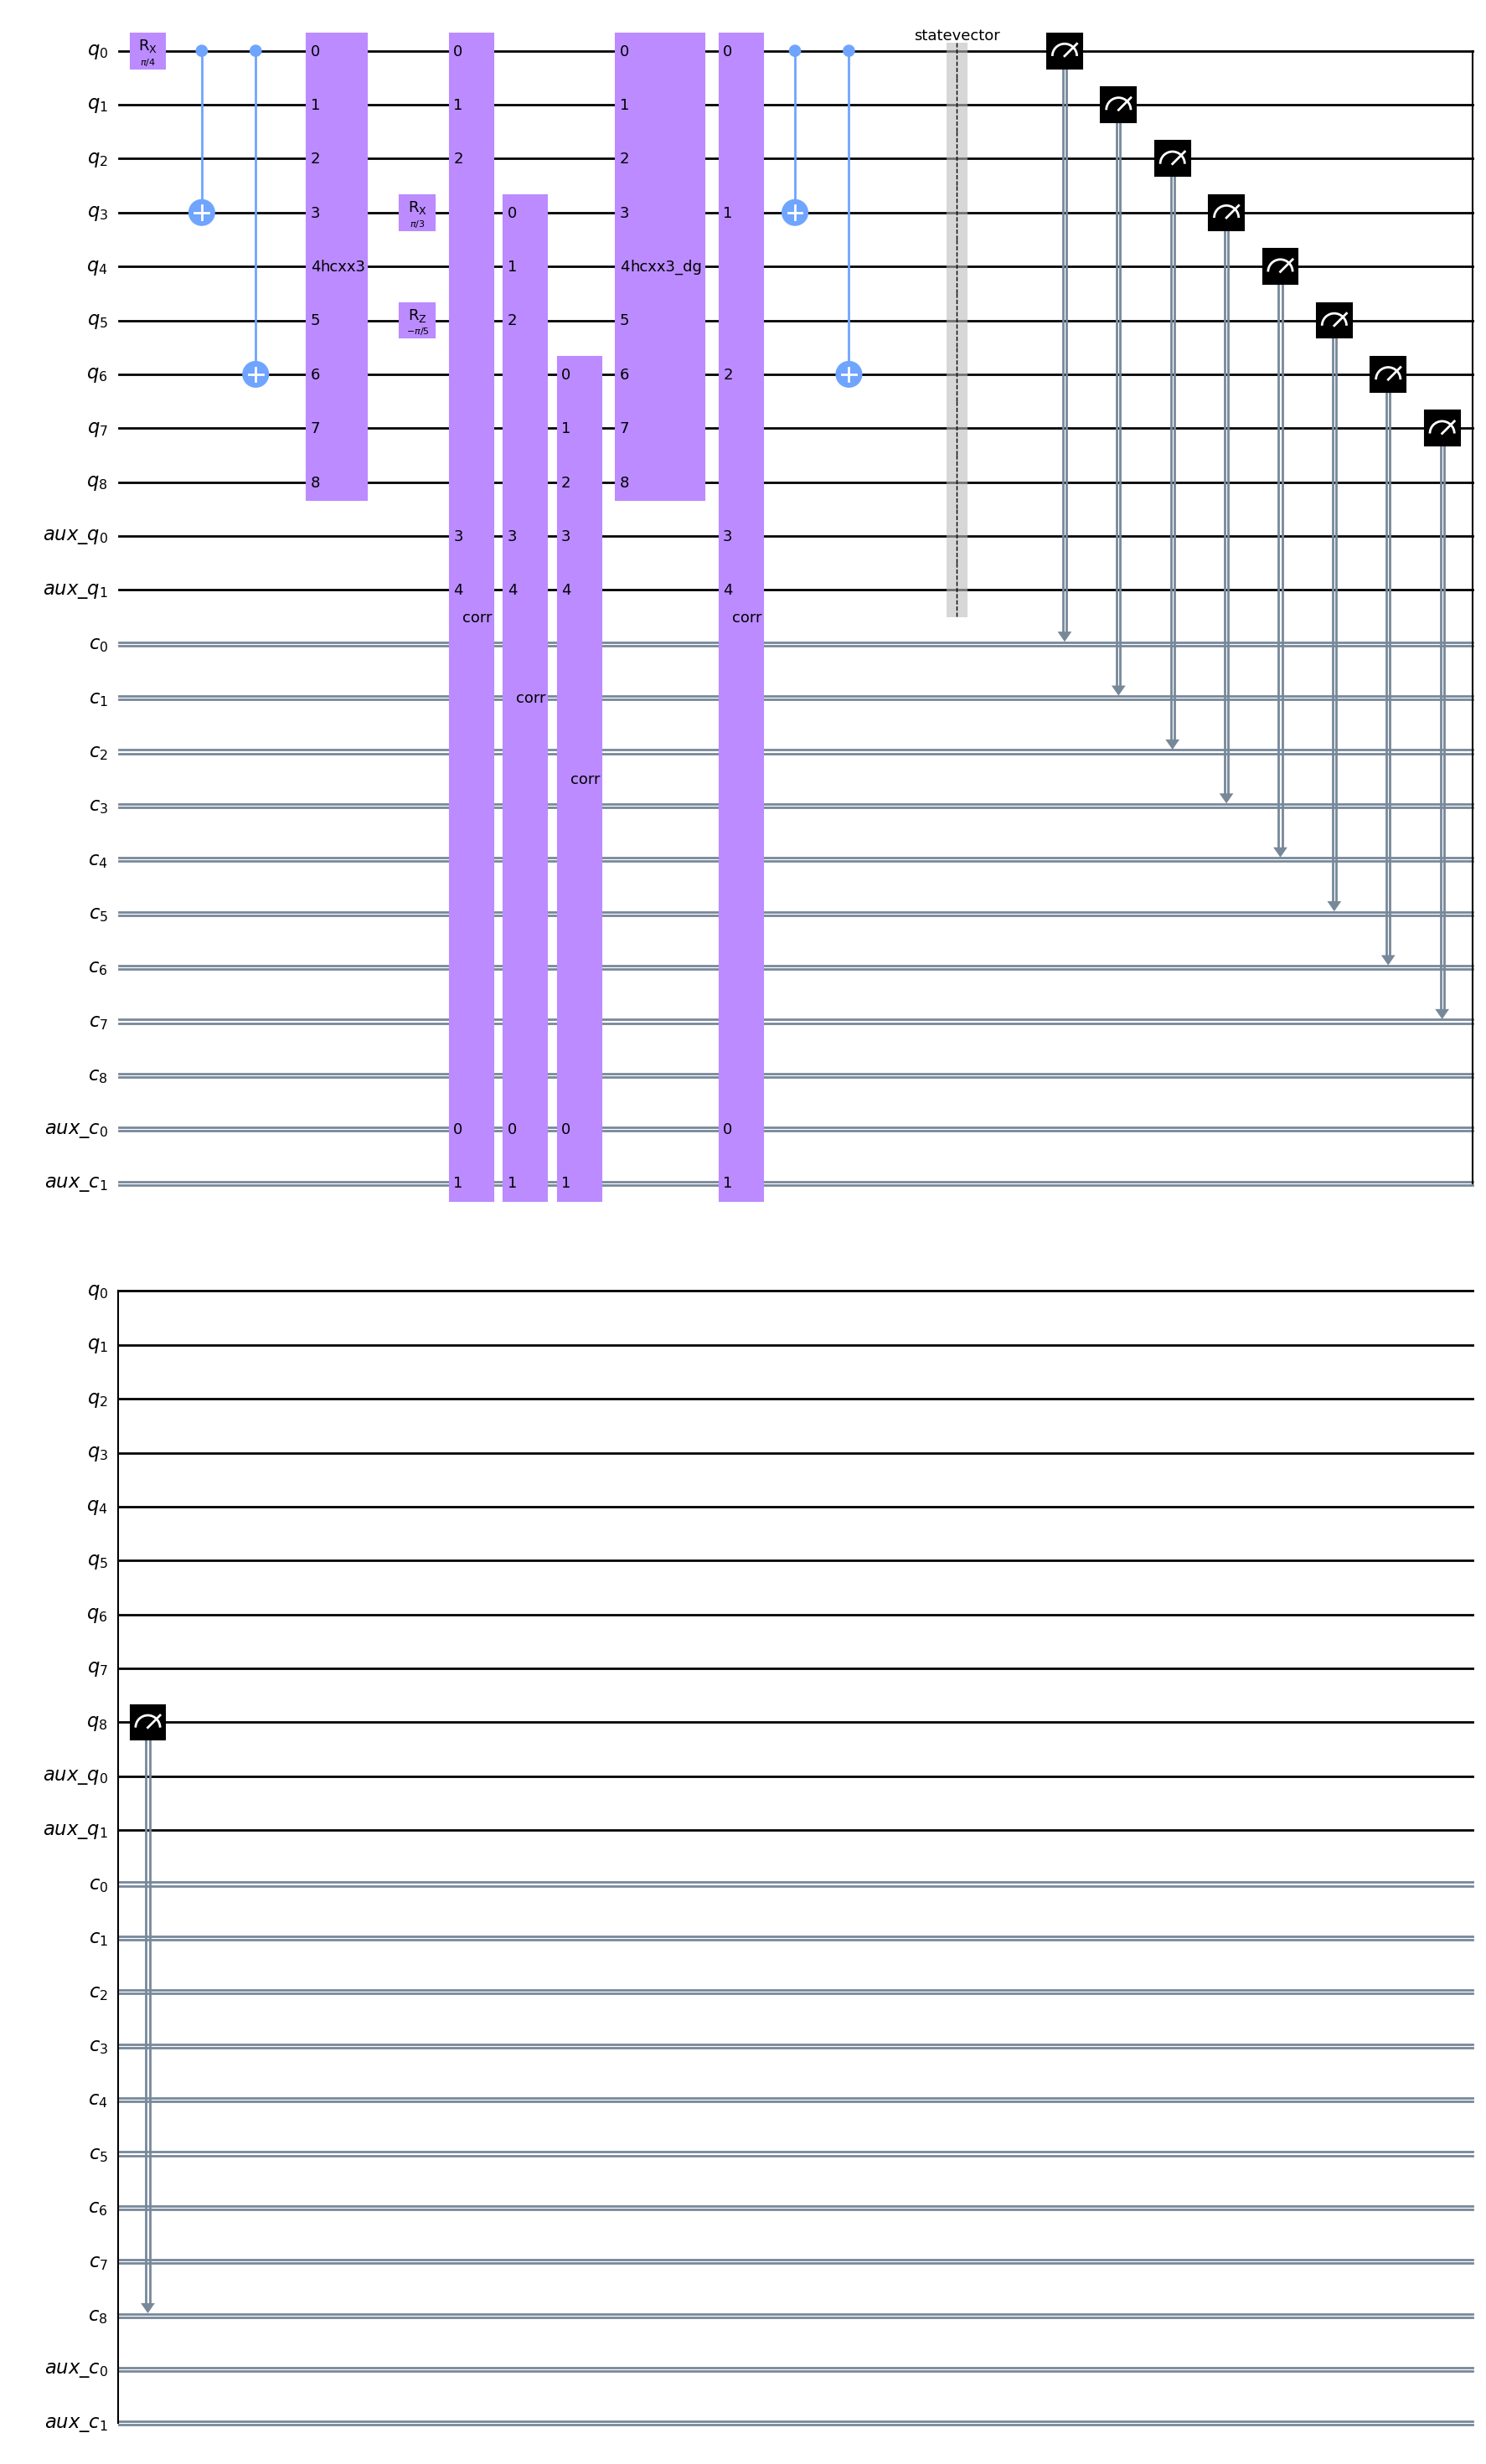

In [3]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi

def corr_circ():
    q = QuantumRegister(3, 'q')
    aux_q = QuantumRegister(2, 'aux_q')
    aux_c = ClassicalRegister(2, 'aux_c')
    qc = QuantumCircuit(q, aux_q, aux_c, name='corr')

    qc.cx(q[0], aux_q[0])
    qc.cx(q[1], aux_q[0])
    qc.cx(q[1], aux_q[1])
    qc.cx(q[2], aux_q[1])

    qc.ccx(aux_q[0], aux_q[1], q[1])
    qc.ccx(aux_q[0], aux_q[1], q[0], ctrl_state='01')
    qc.ccx(aux_q[0], aux_q[1], q[2], ctrl_state='10')

    # measurement deferred
    qc.measure(aux_q, aux_c)
    qc.reset(aux_q)
    qc.measure(aux_q, aux_c)

    return qc

def hcxx3():
    q = QuantumRegister(9, 'q')
    qc = QuantumCircuit(q, name='hcxx3')
    for i in range(3):
        qc.h(q[3*i])
        qc.cx(q[3*i], q[3*i+1])
        qc.cx(q[3*i], q[3*i+2])
    return qc
    
q = QuantumRegister(9, 'q')
c = ClassicalRegister(9, 'c')
aux_q = QuantumRegister(2, 'aux_q')
aux_c = ClassicalRegister(2, 'aux_c')
qc = QuantumCircuit(q, aux_q, c, aux_c)

# initialise q[0]
qc.rx(pi/4, q[0])

# circuit starts

# encode with shor code
qc.cx(q[0], q[3])
qc.cx(q[0], q[6])
qc.append(hcxx3(), q[:])

# disturbance
qc.rx(pi/3, q[3])
qc.rz(-pi/5, q[5])

# correct bit flips
for i in range(3):
    qc.append(corr_circ(), q[(3*i):(3*i+3)] + aux_q[:], aux_c)

# correct phase flips
qc.append(hcxx3().inverse(), q[:])
qc.append(corr_circ(), q[::3] + aux_q[:], aux_c)

# deshor
qc.cx(q[0], q[3])
qc.cx(q[0], q[6])

qc.save_statevector()

qc.measure(q, c)
qc.draw('mpl')

In [4]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

job = simulator.run(compiled_circuit, shots=1000)

result = job.result()
counts = result.get_counts(compiled_circuit)
print("\nCounts:", counts)
print("Statevector:", result.get_statevector(compiled_circuit))

# without disturbance
# 0: 9.23879533e-01-4.35725672e-33j
# 1: 2.34326020e-17-3.82683432e-01j


Counts: {'00 000000000': 848, '00 000000001': 152}
Statevector: Statevector([9.23879533e-01+1.26550054e-16j,
             1.41411407e-16-3.82683432e-01j,
             0.00000000e+00+0.00000000e+00j, ...,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
